In [1]:
import ROOT, os, math, sys, glob
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import mplhep as hep
plt.style.use(hep.style.CMS)

Welcome to JupyROOT 6.28/00


In [2]:
ROOT.gInterpreter.Declare("""
    using Vfloat = const ROOT::RVec<float>&;
    using Vint   = const ROOT::RVec<int>&;
    ROOT::RVec<int> find_bb_tautau(Vint GenPart_pdgId, Vint GenPart_genPartIdxMother, int pdgid_bb, int pdgid_tt) {
        bool Foundbjets = false;
        bool Foundtaus = false;
        int index_b1 = -1;
        int index_b2 = -1;
        int index_t1 = -1;
        int index_t2 = -1;
        for (int i_gen = 0; i_gen < GenPart_pdgId.size(); i_gen ++) {
            if (GenPart_genPartIdxMother.at(i_gen) == -1) continue; // it is the incoming parton
            if ((Foundbjets != true) && (fabs(GenPart_pdgId.at(i_gen)) == 5) && (GenPart_pdgId.at(GenPart_genPartIdxMother.at(i_gen)) == pdgid_bb)) {
                if (index_b1 == -1) index_b1 = i_gen;
                else if (index_b2 == -1) index_b2 = i_gen;
                if ((index_b1 != -1) && (index_b2 != -1)) {
                    Foundbjets = true;
                }
            }
            if ((Foundtaus != true) && (fabs(GenPart_pdgId.at(i_gen)) == 15) && (GenPart_pdgId.at(GenPart_genPartIdxMother.at(i_gen)) == pdgid_tt)) {
                if (index_t1 == -1) index_t1 = i_gen;
                else if (index_t2 == -1) index_t2 = i_gen;
                if ((index_t1 != -1) && (index_t2 != -1)) {
                    Foundtaus = true;
                }
            }
        }
        return {index_b1, index_b2, index_t1, index_t2} ;
    }
""")

True

In [3]:
ROOT.gInterpreter.Declare("""
    using Vfloat = const ROOT::RVec<float>&;
    using Vint   = const ROOT::RVec<int>&;
    bool check_gen_tag_matching(int index_1, int index_2, int bjet1_JetIdx, int bjet2_JetIdx,
            Vfloat GenPart_pt, Vfloat GenPart_eta, Vfloat GenPart_phi, Vfloat GenPart_mass,
            Vfloat Jet_pt, Vfloat Jet_eta, Vfloat Jet_phi, float deltaR) {
        bool matched = false;
        auto b1_gen_tlv = TLorentzVector();
        auto b2_gen_tlv = TLorentzVector();
        auto b1_tag_tlv = TLorentzVector();
        auto b2_tag_tlv = TLorentzVector();
        b1_gen_tlv.SetPtEtaPhiM(GenPart_pt.at(index_1), GenPart_eta.at(index_1), GenPart_phi.at(index_1), GenPart_mass.at(index_1));
        b2_gen_tlv.SetPtEtaPhiM(GenPart_pt.at(index_2), GenPart_eta.at(index_2), GenPart_phi.at(index_2), GenPart_mass.at(index_2));
        b1_tag_tlv.SetPtEtaPhiM(Jet_pt.at(bjet1_JetIdx), Jet_eta.at(bjet1_JetIdx), Jet_phi.at(bjet1_JetIdx), 0);
        b2_tag_tlv.SetPtEtaPhiM(Jet_pt.at(bjet2_JetIdx), Jet_eta.at(bjet2_JetIdx), Jet_phi.at(bjet2_JetIdx), 0);
        if (((b1_gen_tlv.DeltaR(b1_tag_tlv) < deltaR) && (b2_gen_tlv.DeltaR(b2_tag_tlv) < deltaR)) ||
            ((b1_gen_tlv.DeltaR(b2_tag_tlv) < deltaR) && (b2_gen_tlv.DeltaR(b1_tag_tlv) < deltaR))) {
            matched = true;
        }
        return matched;
    }
""")

True

In [68]:
def ComputeHHBTagPurity(folder, pdgid_tt, pdgid_bb, btag_wp):
    
    files = glob.glob(folder + '/*')
    dataframe_files = ROOT.vector(str)()
    for f in files:
        file = ROOT.TFile.Open(f)
        if file.Get("Events"):
            dataframe_files.push_back(f)
    df = ROOT.RDataFrame("Events", dataframe_files)

    df_res2b = df.Filter(f"(Jet_btagDeepFlavB.at(bjet1_JetIdx) > {btag_wp['medium']}) && \
                        (Jet_btagDeepFlavB.at(bjet2_JetIdx) > {btag_wp['medium']})")

    # find index for gen level b jets
    df_res2b = df_res2b.Define("index_b1", f"find_bb_tautau(GenPart_pdgId, GenPart_genPartIdxMother, {pdgid_bb}, {pdgid_tt}).at(0)")
    df_res2b = df_res2b.Define("index_b2", f"find_bb_tautau(GenPart_pdgId, GenPart_genPartIdxMother, {pdgid_bb}, {pdgid_tt}).at(1)")

    # check matching between tagged b jets and gen level b jets
    df_res2b = df_res2b.Define("matched", "check_gen_tag_matching(index_b1, index_b2, bjet1_JetIdx, bjet2_JetIdx,"
            "GenPart_pt, GenPart_eta, GenPart_phi, GenPart_mass, Jet_pt, Jet_eta, Jet_phi, 0.4)")

    df_bb = df_res2b.Filter("(index_b1 != -1) && (index_b2 != -1)")
    df_matched = df_res2b.Filter("matched == 1")

    num = df_matched.Count().GetValue()
    den = df_bb.Count().GetValue()

    return [num/den, num/den * np.sqrt((np.sqrt(num)/num)**2+(np.sqrt(den)/den)**2)]


In [5]:
def SetStyle(x_label, y_label, x_lim = None, y_lim = None, leg_title=''):
    leg = plt.legend(loc = 'upper right', fontsize=20, title=leg_title, title_fontsize=18)
    leg._legend_box.align = "left"
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if x_lim: plt.xlim(x_lim)
    if y_lim: plt.ylim(y_lim)
    plt.grid()
    hep.cms.label(data=True, label="Private Work")

In [80]:
def PlotHHBTagPurity(v_mass, v_purity, v_purity_err, odir, process, fancy_name):
    fig = plt.figure(figsize=(10,10))
    cmap = plt.get_cmap('viridis')
    plt.errorbar(v_mass[0], v_purity[0], yerr=v_purity_err[0], lw=2, linestyle='', marker='o', color=cmap(0.6), label='SM')
    plt.errorbar(v_mass[1:], v_purity[1:], yerr=v_purity_err[1:], lw=2, linestyle='', marker='o', color=cmap(0), label='Resonant')
    SetStyle(x_label="Mass [GeV]", y_label="HHBTag purity", y_lim=0.5)
    plt.legend(loc='upper right', fontsize=20, title=fancy_name)
    plt.savefig(odir + f'/{process}_HHBTag_Purity.png')
    plt.savefig(odir + f'/{process}_HHBTag_Purity.pdf')

# Compute purity for HHBTag on ZZ samples (non-resonant and resonant)

In [82]:
indir = '/data_CMS/cms/vernazza/cmt/PreprocessRDF/'

mass_points = [ 200, 210, 220, 230, 240, 250, 260, 270, 280, 300, 320, 350, 360, 400, 450, 500, 550,
                600, 650, 700, 750, 800, 850, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700,
                1800, 1900, 2000, 2200, 2400, 2500, 2600, 2800, 3000]
cfg = 'ul_2018_ZZ_v12'
ver = 'prod_240305'
sm_name = 'zz_sl_signal'
res_name = 'GluGluToXToZZTo2B2Tau'
cat = 'cat_base_selection'
btag_wp = {'tight':0.7264, 'medium':0.2770, 'loose':0.0494}
process = 'ZZbbtt'
fancy_name = r"$ZZ_{bb\tau\tau}$"
pdgid_bb = 23
pdgid_tt = 23

##########################################################################################

odir = f'/data_CMS/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/HHBTag/{cfg}/{ver}'
print(" ### INFO: Saving output in ", odir)
os.system('mkdir -p ' + odir)

v_mass = []
v_purity = []
v_purity_err = []

sm_folder = f'{indir}/{cfg}/{sm_name}/{cat}/{ver}'
v_mass.append(1)
purity = ComputeHHBTagPurity(sm_folder, pdgid_bb, pdgid_tt, btag_wp)
v_purity.append(purity[0])
v_purity_err.append(purity[1])

for mass in tqdm(mass_points):
    v_mass.append(mass)
    mass_folder = f'{indir}/{cfg}/{res_name}_M{mass}/{cat}/{ver}'
    purity = ComputeHHBTagPurity(mass_folder, pdgid_bb, pdgid_tt, btag_wp)
    v_purity.append(purity[0])
    v_purity_err.append(purity[1])

 ### INFO: Saving output in  /data_CMS/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/HHBTag/ul_2018_ZZ_v12/prod_240305


100%|██████████| 41/41 [00:35<00:00,  1.14it/s]


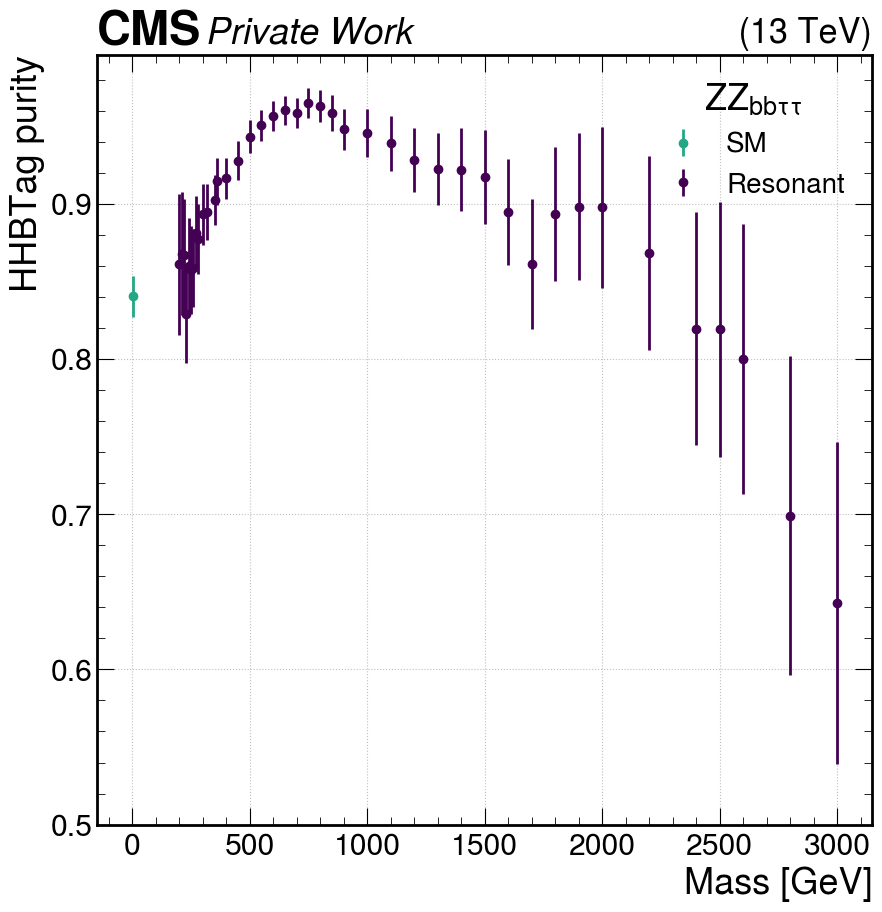

In [83]:
PlotHHBTagPurity(v_mass, v_purity, v_purity_err, odir, process, fancy_name)

In [90]:
for (m,p) in zip(v_mass, v_purity): print(m,p)

1 0.8403167271527548
200 0.861003861003861
210 0.8679060665362035
220 0.8670936749399519
230 0.829088471849866
240 0.8597449908925319
250 0.8571428571428571
260 0.8583895279650933
270 0.8812816188870152
280 0.8771018037297462
300 0.893154486586494
320 0.8947972456006121
350 0.9023646071700991
360 0.9146214099216711
400 0.9162977452898178
450 0.9278289529282515
500 0.943198992443325
550 0.9506192697442496
600 0.9567234894739413
650 0.960223981463603
700 0.9584861450692747
750 0.9649586930288685
800 0.9631504463313738
850 0.9585765916041146
900 0.9478899082568807
1000 0.9454686089983241
1100 0.9389679410252014
1200 0.9281045751633987
1300 0.9225181598062954
1400 0.9219829337667614
1500 0.9172341540073337
1600 0.8947368421052632
1700 0.8611713665943601
1800 0.8934065934065935
1900 0.8981481481481481
2000 0.8976377952755905
2200 0.86810551558753
2400 0.8195488721804511
2500 0.8190045248868778
2600 0.8
2800 0.6991150442477876
3000 0.6428571428571429
3500 0.3939393939393939
4000 0.2777777777

# Compute purity for HHBTag on ZbbHtt samples (non-resonant and resonant)

In [84]:
indir = '/data_CMS/cms/cuisset/cmt/PreprocessRDF/'

mass_points = [600,800,1000,1200,1400,1600,1800,2000,2500,3000]
cfg = 'ul_2018_ZbbHtt_v12'
ver = 'prod_240305'
sm_name = 'zh_zbb_htt_signal'
res_name = 'ZprimeToZH_ZToBB_HToTauTau'
cat = 'cat_base_selection'
btag_wp = {'tight':0.7264, 'medium':0.2770, 'loose':0.0494}
process = 'ZbbHtt'
fancy_name = r"$Z_{bb}H_{\tau\tau}$"
pdgid_bb = 23
pdgid_tt = 25

##########################################################################################

odir = f'/data_CMS/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/HHBTag/{cfg}/{ver}'
print(" ### INFO: Saving output in ", odir)
os.system('mkdir -p ' + odir)

v_mass = []
v_purity = []
v_purity_err = []

sm_folder = f'{indir}/{cfg}/{sm_name}/{cat}/{ver}'
v_mass.append(1)
purity = ComputeHHBTagPurity(sm_folder, pdgid_tt, pdgid_bb, btag_wp)
v_purity.append(purity[0])
v_purity_err.append(purity[1])

for mass in tqdm(mass_points):
    v_mass.append(mass)
    mass_folder = f'{indir}/{cfg}/{res_name}_M{mass}/{cat}/{ver}'
    purity = ComputeHHBTagPurity(mass_folder, pdgid_tt, pdgid_bb, btag_wp)
    v_purity.append(purity[0])
    v_purity_err.append(purity[1])

 ### INFO: Saving output in  /data_CMS/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/HHBTag/ul_2018_ZbbHtt_v12/prod_240305


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


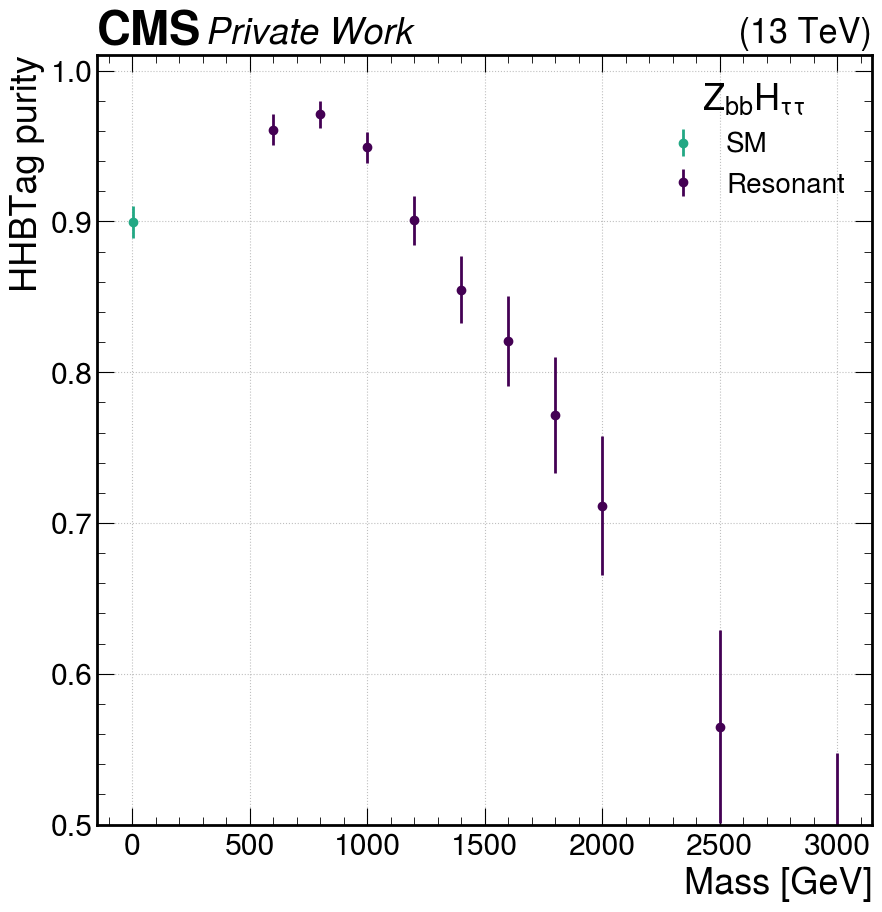

In [85]:
PlotHHBTagPurity(v_mass, v_purity, v_purity_err, odir, process, fancy_name)

In [71]:
for (m,p) in zip(v_mass, v_purity): print(m,p)

1 0.8994224258115913
600 0.9607832260927446
800 0.9710168793742281
1000 0.9490618165074249
1200 0.9006118489777645
1400 0.8547936704933292
1600 0.820677570093458
1800 0.771397616468039
2000 0.7115384615384616
2500 0.5648148148148148
3000 0.4567901234567901
3500 0.3469387755102041
4000 0.08333333333333333
4500 0.11764705882352941
5000 0.0
5500 0.0
6000 0.0


# Compute purity for HHBTag on ZttHbb samples (non-resonant and resonant)

In [86]:
indir = '/data_CMS/cms/cuisset/cmt/PreprocessRDF/'

mass_points = [600,1000,1200,1400,1600,1800,2000,2500,3000]
cfg = 'ul_2018_ZttHbb_v12'
ver = 'prod_240305'
sm_name = 'zh_ztt_hbb_signal'
res_name = 'ZprimeToZH_ZToTauTau_HToBB'
cat = 'cat_base_selection'
btag_wp = {'tight':0.7264, 'medium':0.2770, 'loose':0.0494}
process = 'ZttHbb'
fancy_name = r"$Z_{\tau\tau}H_{bb}$"
pdgid_bb = 25
pdgid_tt = 23

##########################################################################################

odir = f'/data_CMS/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/HHBTag/{cfg}/{ver}'
print(" ### INFO: Saving output in ", odir)
os.system('mkdir -p ' + odir)

v_mass = []
v_purity = []
v_purity_err = []

sm_folder = f'{indir}/{cfg}/{sm_name}/{cat}/{ver}'
v_mass.append(1)
purity = ComputeHHBTagPurity(sm_folder, pdgid_tt, pdgid_bb, btag_wp)
v_purity.append(purity[0])
v_purity_err.append(purity[1])

for mass in tqdm(mass_points):
    v_mass.append(mass)
    mass_folder = f'{indir}/{cfg}/{res_name}_M{mass}/{cat}/{ver}'
    purity = ComputeHHBTagPurity(mass_folder, pdgid_tt, pdgid_bb, btag_wp)
    v_purity.append(purity[0])
    v_purity_err.append(purity[1])

 ### INFO: Saving output in  /data_CMS/cms/vernazza/FrameworkNanoAOD/hhbbtt-analysis/nicePlots/HHBTag/ul_2018_ZttHbb_v12/prod_240305


100%|██████████| 9/9 [00:08<00:00,  1.11it/s]


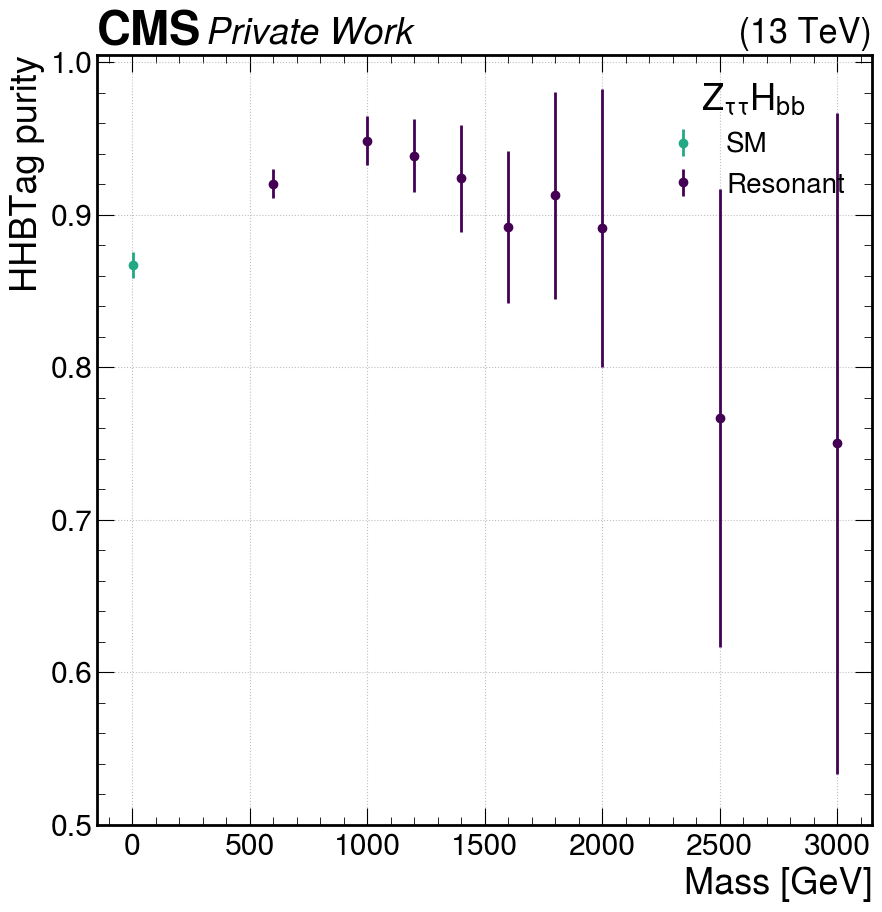

In [87]:
PlotHHBTagPurity(v_mass, v_purity, v_purity_err, odir, process, fancy_name)

In [74]:
for (m,p) in zip(v_mass, v_purity): print(m,p)

1 0.8669148441135411
600 0.9202917985302794
1000 0.9483808469415997
1200 0.9386327503974563
1400 0.9237113402061856
1600 0.8920118343195266
1800 0.9126984126984127
2000 0.8910891089108911
2500 0.7666666666666667
3000 0.75
3500 0.47058823529411764
4000 0.3333333333333333
4500 0.4
5000 0.4
5500 0.25
6000 0.2857142857142857
